# 머신러닝과 딥러닝 프로젝트 코드

## 머신러닝 알고리즘을 통한 서울지역 아파트 실거래가 예측

### 2015313693 통계학과 권남택

## 1. 문제

서울 지역의 아파트 실거래가를 예측하는 머신러닝 알고리즘을 구축하려고 한다. 한국인의 절반 가까이는 아파트에 거주하고 있으며, 한국에서 아파트는 인기있는 투자 자산이다. 그렇기 때문에 아파트 가격에 대한 관심이 높지만, 최근의 아파트 거래에 대한 정보 업데이트는 다소 느린 편이다. 따라서 주어진 데이터로 아파트 거래가를 예측하는 알고리즘을 개발해, 아파트 구매자들의 비대칭성을 해소하려 한다.

## 2. 데이터 

우리의 데이터는 *'직방'* 에서 제공한 데이터로, 한국의 Kaggle인 Dacon 4회 컴피티션의 데이터이다. 1,100,000여 개의 학습데이터와, 500,000개의 평가 데이터가 주어져 있는데, 평가데이터에는 **y**값이 제공되지 않기 때문에 학습데이터를 분리해 모델링을 진행한다. 또한 서울지역의 실거래가에만 관심있기 때문에, 서울로 한정한 모델링을 진행한다

이 데이터에는 우리가 예측하고자 하는 *y = 아파트 실거래가* 와 아파트 거래일, 지역, 전용면적, 공급면적 등의 정보가 포함된다. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import math # 삼각변환 위한 패키지

## 3. 데이터 확인

### 3-1. 변수확인 및 제거

In [2]:
dat = pd.read_csv('data.csv')

In [3]:
print('이 데이터의 행과 열은 ', dat.shape)
dat.head()

이 데이터의 행과 열은  (1216553, 13)


,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [4]:
dat = dat.drop(columns = ['transaction_id', 'apartment_id', 'jibun', 'addr_kr']) 
# id값은 idx이므로 삭제
# 지번값은 지나치게 구체적이고, 아파트와 동일한정보를 갖고 있으므로 삭제.
# addr_kr = 아파트와 아파트 주소도 같은 이유로 삭제한다

In [5]:
dat = dat[dat['city'] == '서울특별시']
dat = dat.reset_index(drop = True)
dat = dat.drop(columns = 'city')

# 서울 집값에 관심있으므로 서울시만 추출하고, 망가진 인덱싱 수정

### 3-2. 데이터 정제 및 파생 변수 

In [6]:
trans = dat['transaction_year_month'].astype(str)
dat['transaction_year'] = trans.str.slice(start = 0, stop = 4)
dat['transaction_month'] = trans.str.slice(start = 4, stop = 6)

# 연도와 월 변수 추출

In [7]:
dat = dat[dat['transaction_year'].astype(int) > 2011]

# 데이터도 많고, 최근의 데이터를 사용하는것이 적절하므로 2012년부터의 데이터만 사용한다.

In [8]:
# 파생변수 생성

# 1. 거래될때의 아파트 연차
# 아파트의 연차가 오래될수록 거래가는 낮아질것이라는 판단
# 단순한 거래연도나 건축연도보다 더 좋은 정보를 가질 것!
dat['until_trans'] = dat['transaction_year'].astype(int) - dat['year_of_completion'] + 1

# 2. 시간에 대한 삼각 변환
# 거래에는 연도별 주기성이 있을것이라는 판단.

dat['transaction_date'] = np.where(dat['transaction_date'] == '1~10', 0, np.where(dat['transaction_date'] == '11~20', 1, 2))
# 1~10, 11~20, 21~31을 0, 1, 2으로 변환함으로써 삼각변환을 위한 작업.
dat['transaction_month_date'] = dat['transaction_month'].astype(int) * 3 + dat['transaction_date']
# 삼각변환을 위해 월(month)와 일자를 동시에 고려


dat['sin_time'] = dat['transaction_month_date'].apply(lambda x: math.sin(x* math.pi*2 / 12*3))
dat['cos_time'] = dat['transaction_month_date'].apply(lambda x: math.cos(x* math.pi*2 / 12*3))
# sin-cos으로 변환할때 연속함수로 만들어주기 위해 2*pi 곱해줌


# 파생변수를 위해 생성한 변수들 제거
dat = dat.drop(columns = ['year_of_completion', 'transaction_year_month', 'transaction_date'])
dat = dat.drop(columns = ['transaction_month', 'transaction_month_date'])

### 3-3. 인코딩 방법

In [9]:
# 연도 라벨인코딩 

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(dat['transaction_year'])
dat['transaction_year'] = le.transform(dat['transaction_year'])

# 라벨인코딩은 각각의 연도에 따른 물가상승을 고려해줄 수 있는 인코딩이라고 생각했다.
# 단순한 원핫인코딩으로 고려되지 않는 특성을 잘 반영할 수 있고, 
# 미래의 값으로 현재를 예측하는 일이 일어나지 않도록 데이터를 처리해줄 수 있다.

In [10]:
dat.head()

,dong,apt,exclusive_use_area,floor,transaction_real_price,transaction_year,until_trans,sin_time,cos_time
1770,사직동,광화문풍림스페이스본(9-0),95.88,6,70000,0,5,-1.000000e+00,-1.836970e-16
1771,사직동,광화문풍림스페이스본(9-0),108.55,11,100500,0,5,-2.449294e-16,1.000000e+00
1772,사직동,광화문풍림스페이스본(9-0),94.51,1,65800,0,5,-2.449294e-16,1.000000e+00
1773,수송동,로얄팰리스스위트,42.87,8,30500,0,8,-1.000000e+00,-1.836970e-16
1774,수송동,로얄팰리스스위트,39.67,15,30500,0,8,1.000000e+00,3.061617e-16


### 3-4. 데이터 분할

In [11]:
dat_x = dat.drop(['transaction_real_price'], axis = 1)
dat_y = dat.loc[:, ['transaction_real_price']]
dat_y = dat_y / 100

# catboost encoding시 beta 계수들의 variation을 어느정도 보정해주기 위해!
# 이후 예측값 반환시 수정하면 된다.

In [12]:
train_x = dat_x[dat['transaction_year'] < 5]
train_y = dat_y[dat['transaction_year'] < 5]

test_x = dat_x[dat['transaction_year'] == 5]
test_y = dat_y[dat['transaction_year'] == 5]

In [13]:
val_x = dat_x[dat['transaction_year'] == 4]
val_y = dat_y[dat['transaction_year'] == 4]

In [14]:
train_tune_x = dat_x[dat['transaction_year'] < 4]
train_tune_y = dat_y[dat['transaction_year'] < 4]

In [15]:
del(dat_x)
del(dat_y)

캣부스트 인코더 - Ordered Target Encoding

In [16]:
! pip install category_encoders

In [17]:
from category_encoders.cat_boost import CatBoostEncoder

def catboost_encoder(train_x, train_y, test_x):
  cate_var = list(train_x.select_dtypes(include=['object']))
  encoder = CatBoostEncoder()
  cbe_train_x = encoder.fit_transform(train_x[cate_var], train_y)
  cbe_test_x = encoder.transform(test_x[cate_var])
  cbe_train_result = (np.concatenate((cbe_train_x, train_x.loc[:,['exclusive_use_area', 'floor', 'transaction_year', 
                                                                  'until_trans', 'sin_time', 'cos_time']]), axis=1))
  cbe_test_result = (np.concatenate((cbe_test_x, test_x.loc[:,['exclusive_use_area', 'floor', 'transaction_year', 
                                                               'until_trans', 'sin_time', 'cos_time']]), axis=1))
  cbe_final_train = pd.DataFrame(cbe_train_result, columns= train_x.columns)
  cbe_final_test = pd.DataFrame(cbe_test_result, columns= test_x.columns)
  return(cbe_final_train, cbe_final_test)

In [18]:
train_tune_x, val_x = catboost_encoder(train_tune_x, train_tune_y, val_x)

In [19]:
train_tune_x.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_time,cos_time
0,460.566183,460.566183,95.88,6.0,0.0,5.0,-1.000000e+00,-1.836970e-16
1,580.283092,580.283092,108.55,11.0,0.0,5.0,-2.449294e-16,1.000000e+00
2,721.855394,721.855394,94.51,1.0,0.0,5.0,-2.449294e-16,1.000000e+00
3,460.566183,460.566183,42.87,8.0,0.0,8.0,-1.000000e+00,-1.836970e-16
4,382.783092,382.783092,39.67,15.0,0.0,8.0,1.000000e+00,3.061617e-16


In [20]:
train_x, test_x = catboost_encoder(train_x, train_y, test_x)

In [21]:
test_x

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_time,cos_time
0,918.272277,893.690511,70.80,1.0,5.0,10.0,-1.000000e+00,-1.836970e-16
1,918.272277,893.690511,94.51,8.0,5.0,10.0,-2.449294e-16,1.000000e+00
2,918.272277,893.690511,160.85,11.0,5.0,10.0,-2.449294e-16,1.000000e+00
3,918.272277,893.690511,94.51,6.0,5.0,10.0,1.000000e+00,3.061617e-16
4,918.272277,893.690511,136.40,3.0,5.0,10.0,1.000000e+00,3.061617e-16
...,...,...,...,...,...,...,...,...
91359,428.970895,482.389892,59.72,9.0,5.0,7.0,-1.470814e-15,-1.000000e+00
91360,428.970895,411.808187,59.87,12.0,5.0,9.0,-1.000000e+00,-3.919489e-15
91361,428.970895,411.808187,84.74,3.0,5.0,9.0,-1.000000e+00,-3.919489e-15
91362,428.970895,417.378246,84.74,9.0,5.0,9.0,-1.000000e+00,-3.919489e-15


## 4. 모델링

### 4-1. linear regression

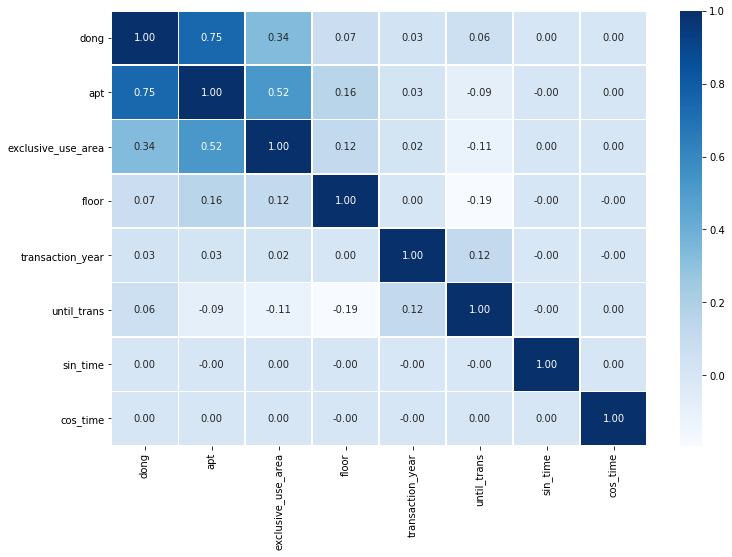

In [22]:
plt.figure(figsize=(12,8))
sns.heatmap(data = train_x.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

선형회귀의 가장 큰 문제는 **다중공선성**이다. 다중공선성을 해결하기위해 변수선택도 하고, 차원축소도 하고, ridge-lasso도 사용한다.

하지만 상관계수 플랏을 보면 알 수 있듯, 다중공선성이 없고, 변수들간의 상관계수가 매우 낮음을 확인할 수 있다.
이런 경우 모든 변수를 사용해서 일반 선형회귀를 하는 것이 가장 좋은 성능을 기대할 수 있으면서, 좋은 해석력을 가진다.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(train_tune_x, train_tune_y)
pred_y = lin_reg.predict(val_x)
rmse_lin = sqrt(mean_squared_error(val_y, pred_y))
print('RMSE of linear regression is', rmse_lin)

lin_reg_test = LinearRegression()
lin_reg_test.fit(train_x, train_y)

RMSE of linear regression is 147.77881419492016


LinearRegression()

### 4-2. Decision Tree

linear regression에서 좋은 성능이 나온 것 같아서, 모델의 복잡도를 많이 늘리지는 않지만, 비선형적 관계를 고려하는 트리모델를 선택했다.

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
best_tree_score = 10000
each_score = []
parm_depth = [4, 6, 8, 10, 12, 14, 16, 18, 20]

for depth in parm_depth:
        # decision tree
    tree_reg = DecisionTreeRegressor(random_state = 42, criterion = 'mse', max_depth = depth)
    tree_reg.fit(train_tune_x, train_tune_y)
        # 검증
    pred_y = tree_reg.predict(val_x)
    rmse_tree = sqrt(mean_squared_error(val_y, pred_y))
    
    each_score.append(rmse_tree)

        # RMSE가 더 작으면 기록합니다.
    if rmse_tree < best_tree_score:
        best_tree_score = rmse_tree
        best_parameters = {'depth': depth}
        
print(best_parameters)
print(best_tree_score)
print(each_score)

{'depth': 14}
119.81279718583274
[171.05405527332843, 150.77431867954445, 134.22738560221975, 124.20479873783823, 120.39202133477393, 119.81279718583274, 120.25648025731483, 120.93836671852198, 121.55650198234771]


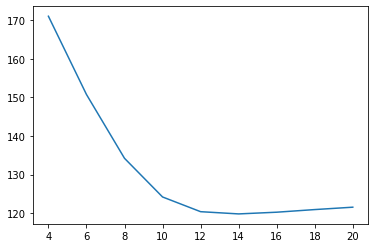

In [27]:
sns.lineplot(x = parm_depth, y = each_score)

depth=14일때 rmse는 119.81로 regression보다 더 좋은 성능을 발휘했다.

In [28]:
tree_reg_test = DecisionTreeRegressor(random_state = 42, criterion = 'mse', max_depth = 14)
tree_reg_test.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=14, random_state=42)

### 트리 시각화

깊이가 너무 깊기때문에 깊이를 줄여서 시각화하겠다.

|--- feature_1 <= 671.65
|   |--- feature_1 <= 395.49
|   |   |--- feature_2 <= 74.53
|   |   |   |--- value: [256.27]
|   |   |--- feature_2 >  74.53
|   |   |   |--- value: [383.59]
|   |--- feature_1 >  395.49
|   |   |--- feature_2 <= 88.26
|   |   |   |--- value: [473.63]
|   |   |--- feature_2 >  88.26
|   |   |   |--- value: [666.18]
|--- feature_1 >  671.65
|   |--- feature_1 <= 1230.05
|   |   |--- feature_2 <= 106.13
|   |   |   |--- value: [818.82]
|   |   |--- feature_2 >  106.13
|   |   |   |--- value: [1127.21]
|   |--- feature_1 >  1230.05
|   |   |--- feature_2 <= 167.58
|   |   |   |--- value: [1515.50]
|   |   |--- feature_2 >  167.58
|   |   |   |--- value: [2446.60]



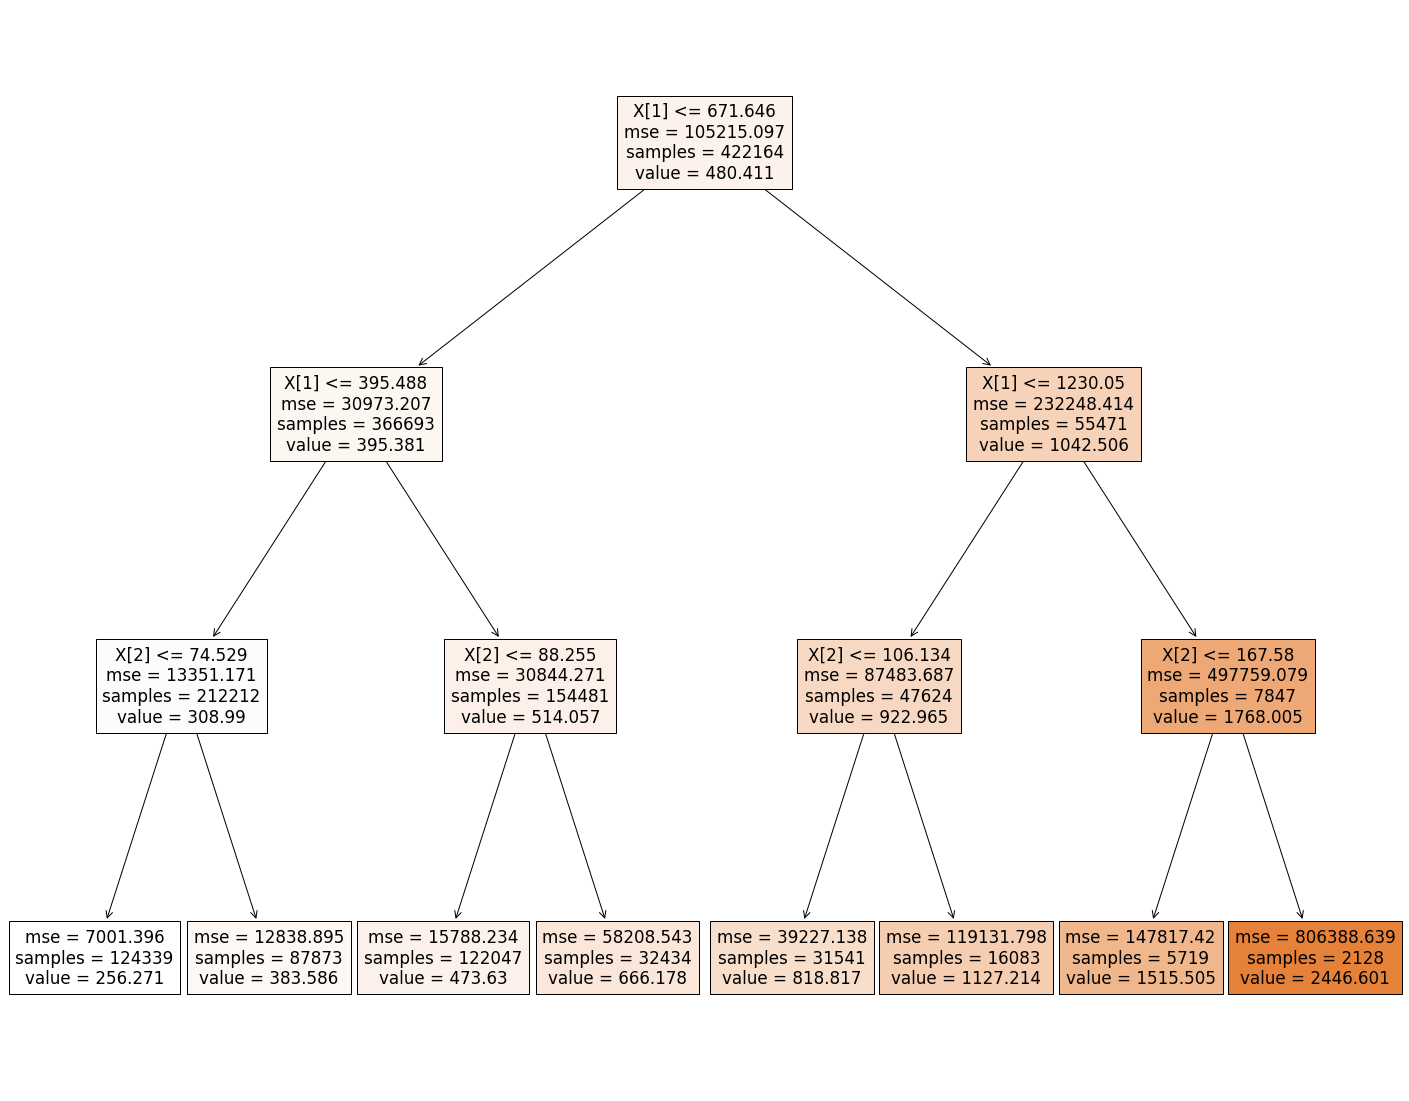

In [30]:
from sklearn import tree

tree_reg_visual = DecisionTreeRegressor(random_state = 42, criterion = 'mse', max_depth = 3)
tree_reg_visual.fit(train_x, train_y)

text_representation = tree.export_text(tree_reg_visual)
print(text_representation)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_reg_visual, 
                   #feature_names=boston.feature_names, 
                   filled=True)

###  4- 3. adaboost

데이터가 많기 때문에 부스팅 모델은 변수들의 비선형적 관계를 포착해 좋은 성능을 기대할 수 있을 것이다.

In [31]:
from sklearn.ensemble import AdaBoostRegressor

In [32]:
best_ada_score = 10000

each_score = []
parm_lr = [0.4, 0.5, 0.6, 0.65, 0.7]

for lr in parm_lr:
        # adaboost
    ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth = 7), n_estimators = 100,
    learning_rate = lr, random_state = 42)
    ada_reg.fit(train_tune_x, train_tune_y)
        # 검증
    pred_y = ada_reg.predict(val_x)
    rmse_ada = sqrt(mean_squared_error(val_y, pred_y))
    
    each_score.append(rmse_ada)

        # RMSE가 더 작으면 기록합니다.
    if rmse_ada < best_ada_score:
        best_ada_score = rmse_ada
        best_parameters = {'lr': lr}
        
print(best_parameters)
print(best_ada_score)
print(each_score)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

{'lr': 0.65}
127.8994514990377
[129.63657830635034, 129.2316732578398, 128.96108372544674, 127.8994514990377, 129.32634293676114]


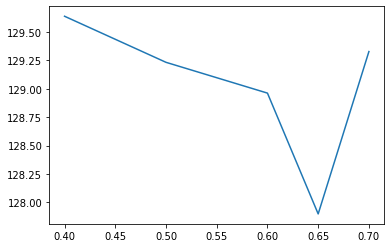

In [33]:
sns.lineplot(x = parm_lr, y = each_score)

In [34]:
ada_reg_test = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth = 7), n_estimators = 100,
    learning_rate = 0.65, random_state = 42)
ada_reg_test.fit(train_tune_x, train_tune_y)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7),
                  learning_rate=0.65, n_estimators=100, random_state=42)

In [35]:
print('RMSE of linear regression is', rmse_lin)
print('RMSE of decision tree is', best_tree_score)
print('RMSE of adaboost is', best_ada_score)

RMSE of linear regression is 147.77881419492016
RMSE of decision tree is 119.81279718583274
RMSE of adaboost is 127.8994514990377


## 5. Predict 결과

In [36]:
test_pred_y = lin_reg_test.predict(test_x)
test_rmse_lin = sqrt(mean_squared_error(test_y, test_pred_y))

test_pred_y = tree_reg_test.predict(test_x)
test_rmse_tree = sqrt(mean_squared_error(test_y, test_pred_y))

test_pred_y = ada_reg_test.predict(test_x)
test_rmse_ada = sqrt(mean_squared_error(test_y, test_pred_y))

In [37]:
print('RMSE of linear regression is', test_rmse_lin)
print('RMSE of decision tree is', test_rmse_tree)
print('RMSE of adaboost is', test_rmse_ada)

RMSE of linear regression is 163.5062741282271
RMSE of decision tree is 145.97882005216687
RMSE of adaboost is 173.21904030894996
